In [1]:
%pip install "roboquant[yahoo]" "matplotlib" --quiet

from datetime import timedelta
from matplotlib import pyplot as plt
import roboquant as rq

print("roboquant", rq.__version__)

Note: you may need to restart the kernel to use updated packages.
roboquant 0.6.2


# Feed
In order to run a strategy, we first need some data. In roboquant, data is provided by a `Feed`. 

In this example we'll use market data from Yahoo Finance.

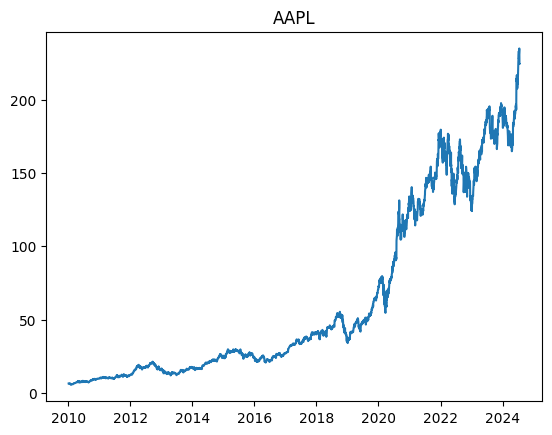

In [2]:
feed = rq.feeds.YahooFeed("TSLA", "AAPL", "F", "JPM", start_date="2010-01-01")
asset = feed.assets()[0]
feed.plot(plt, asset)

It is always good to inspect the data that we planning to use. So we plot the prices for the symbols in the feed.
We can plot a single symbol at a time, or use subplots.

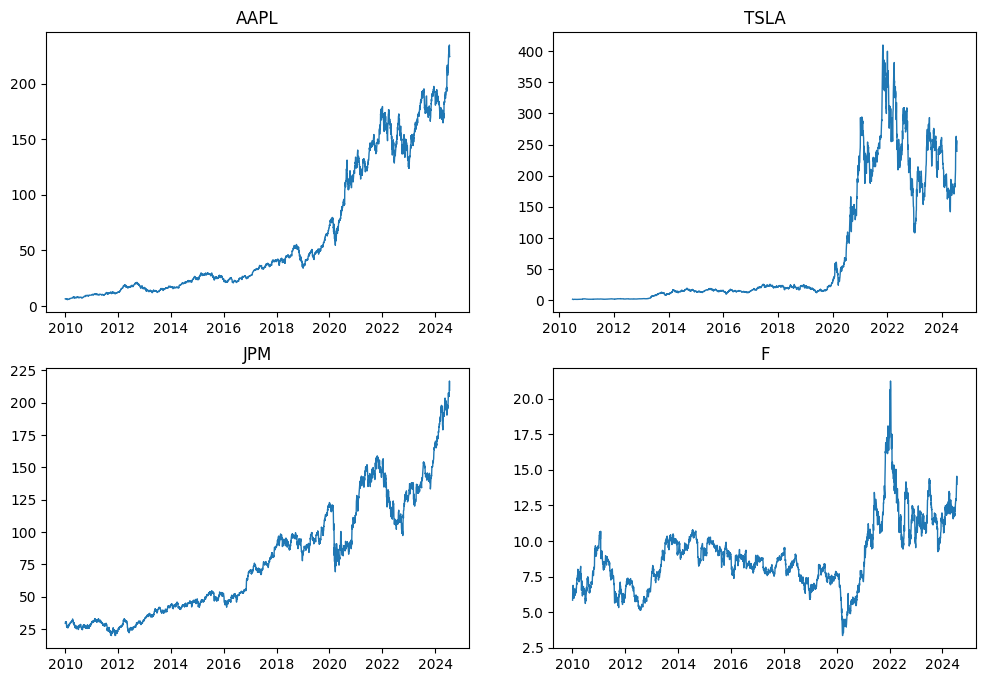

In [3]:
_, axs = plt.subplots(2,2, figsize=(12, 8))

axs = axs.flatten()
for ax, asset in zip(axs, feed.assets()):
    feed.plot(ax, asset, linewidth=1)

# Single back-test

We start with a simple backtest that will run once over all the available data in the feed. We'll also collect some P&L metrics so we have something to plot.

As our strategy we'll use the included EMA (Exponential Moving Average) crossover with its default values.

In [4]:
strategy = rq.strategies.EMACrossover()
journal =  rq.journals.MetricsJournal.pnl()
rq.run(feed, strategy, journal = journal)

buying power : 861663.5198969556 USD
cash         : 1064222.1398969556 USD
equity       : 2176766.956547346 USD
positions    : 2683@TSLA, 1053@AAPL, 999@JPM
mkt value    : 1112544.8166503906 USD
orders       : 16153@F
last update  : 2024-07-19 04:00:00+00:00

We can now plot the captured equity values to see how we have done. 

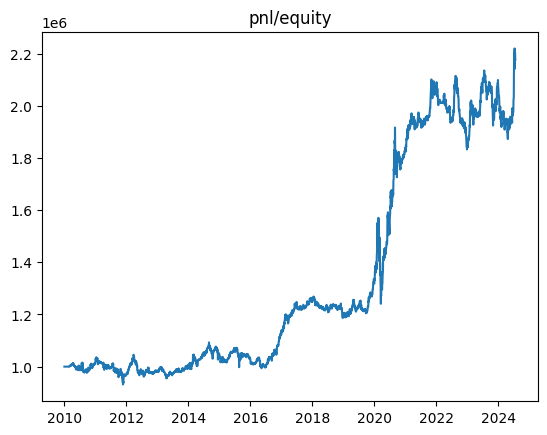

In [5]:
journal.plot(plt, "pnl/equity")

Now lets plot all the metrics we captured during the run

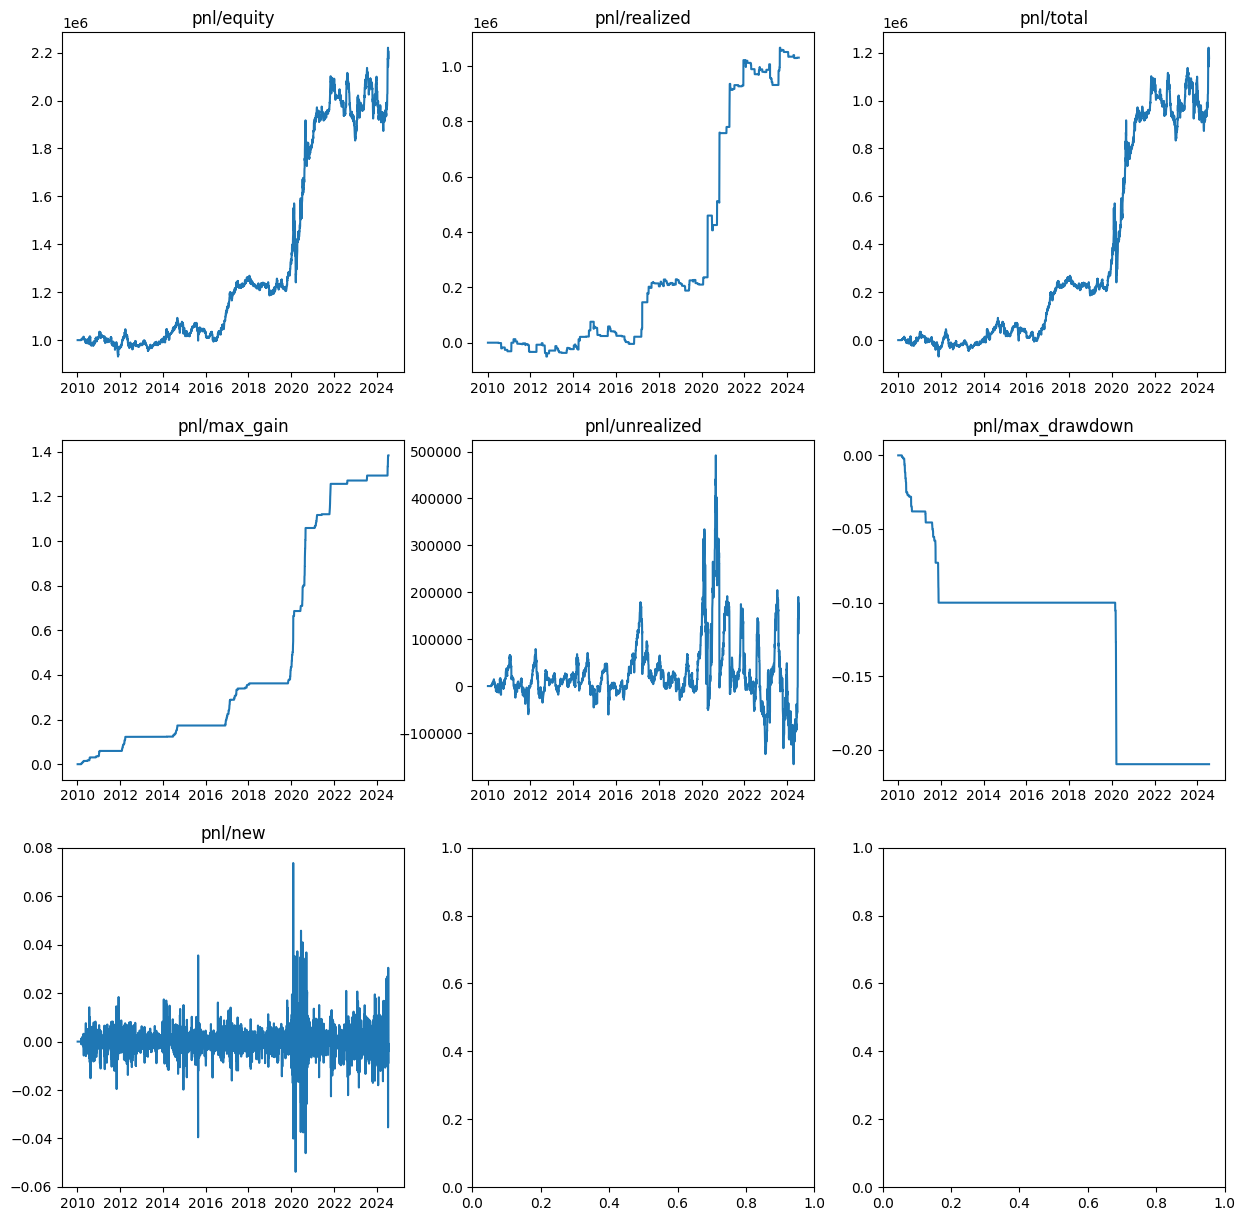

In [6]:
metric_names = journal.get_metric_names()
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for ax, metric_name in zip(axs, metric_names):
    journal.plot(ax, metric_name)

# Walk forward
Instead of a single backtest, we can also run a walk-forward.

We split the overall timeframe of the feed into 4 equal parts and run our backtest in a loop over each part.

At the end of each iteration we plot the equity. Since we don't call a `plt.show()` between the iterations, the results will be plotted on the same chart.

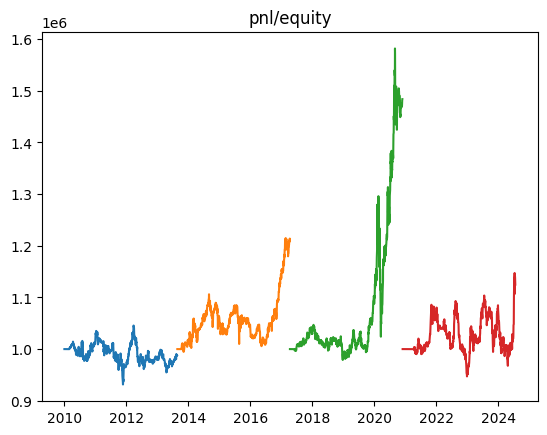

In [7]:
def run_and_plot_equity(timeframe, **kwargs):
    strategy = rq.strategies.EMACrossover()
    journal =  rq.journals.MetricsJournal.pnl()
    rq.run(feed, strategy, journal = journal, timeframe = timeframe)
    journal.plot(plt, "pnl/equity", **kwargs) 
  
for timeframe in feed.timeframe().split(4):
    run_and_plot_equity(timeframe)

# Monte Carlo simulation
We can even take it one step further, and run a Monte Carlo type of simulation over many more timeframes.

We'll sample 200 timeframes, each covering a 2-years period. And then we run our backtest again over each timeframe.

Notice that when we plot the equity this time we provide `plot_x=False`. This will result in each run being plottted as a sequence of steps and not in a timeline. 

We can now nicely compare the variance of our runs and might better understand the possible outcomes. 

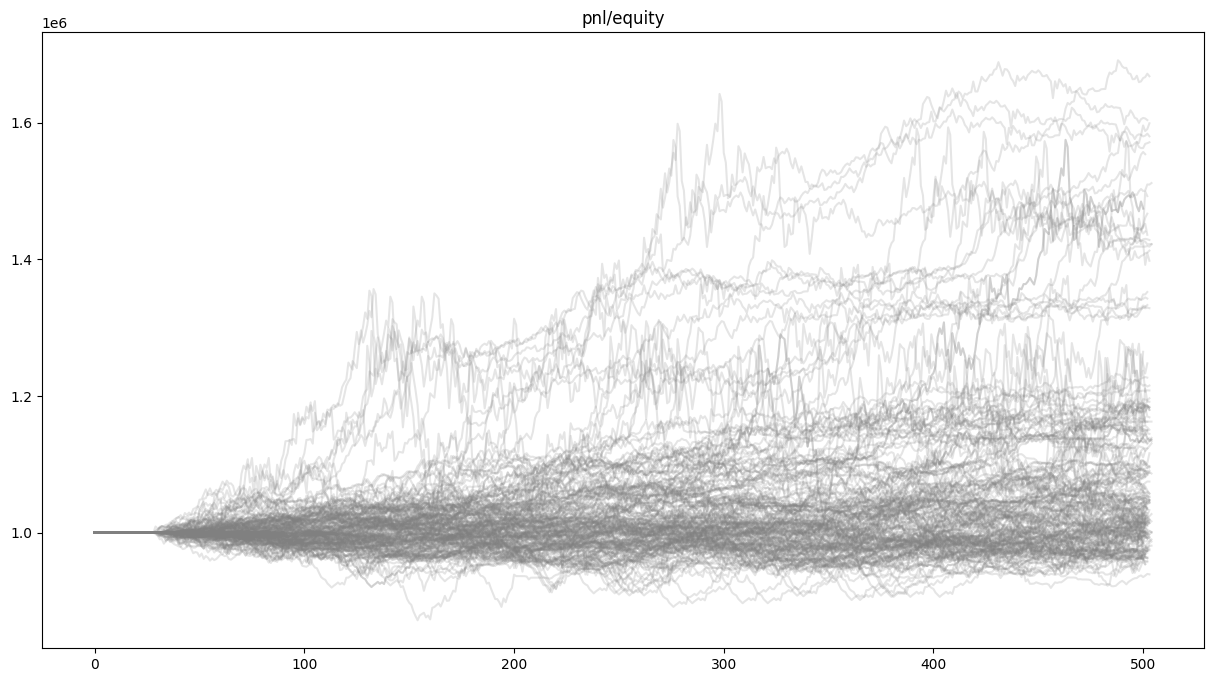

In [8]:
two_year = timedelta(days=365*2)

# sample 200 timeframes, each of two-year period
timeframes = feed.timeframe().sample(two_year, 200)

plt.figure(figsize=(15, 8))

for timeframe in timeframes:
    run_and_plot_equity(timeframe, plot_x=False, color="grey", alpha=0.2)